# Tutorial 2: Structured Jet Model

This tutorial covers the full **structured jet model** — the primary model in the MAGGPY framework. Unlike the top-hat model (Tutorial 1), the structured jet includes:

- **Angular profiles** $R_F(\theta_v)$ and $R_E(\theta_v)$ for flux and energy
- **Temporal evolution** of the pulse (peak time, T90)
- **7 free parameters** including the jet fraction $f_j$

## Tutorial Outline

1. Define parameters and priors
2. Initialize the simulation
3. Run the MCMC
4. Convergence diagnostics
5. Posterior predictive checks (CDFs)
6. Generate observables with custom cuts (for different experiments)
7. Viewing angle vs redshift for all and detected GRBs

## Import Libraries

In [27]:
%load_ext autoreload
%autoreload 2
import notebook_setup

from    src import init, posteriors, plots_oop
import  emcee
import  numpy                   as np
import  matplotlib.pyplot       as plt
from    math                    import inf
from    pathlib                 import Path
from    src.montecarlo          import log_likelihood, DEFAULT_LIMITS
from    src.prior_factory       import create_log_prior, initialize_walkers
from    src.multiprocessing_MC  import run_mcmc_parallel

# Custom plotting style
#plt.style.use('../configurations/style.mplstyle')

import matplotlib as mpl
import matplotlib.colors as mcolors
colors_for_cycle = [
    mcolors.to_hex(c) for c in plt.cm.plasma(np.linspace(0, 1, 3))
]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors_for_cycle)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Key Concepts: From Top-Hat to Structured Jets

### Angular Structure

Unlike a top-hat jet (Tutorial 1), a **structured jet** has luminosity and spectral properties that vary smoothly with the viewing angle $\theta_v$. The key profiles are:

- $R_F(\theta_v)$: the **flux ratio** — how the observed flux drops as you move away from the jet axis
- $R_E(\theta_v)$: the **energy ratio** — how the peak energy shifts off-axis

Both profiles are roughly constant within the jet **core** $\theta_v \lesssim \theta_c$ and decay steeply outside. The core half-opening angle $\theta_c = 3.4°$ is fixed from GW170817 constraints.

![Structured Jet Profile](images/structured_jet_profile.png)

### Temporal Evolution (Light Curve)

The structured jet model also includes **time evolution** of the GRB pulse. The schematic behaviour is:

- **Rise phase**: the flux increases up to the peak time $t_p$
- **Decay phase**: after $t_p$, the flux decays as a power law

The parameters `L_mu_tau` and `sigma_tau` control the **distribution** of peak times across the population (drawn from a log-normal).

![Temporal Profile](images/joint_fit_lightcurves.png)

This is an example fit of the model with **real sGRB data**.

### Recap: SBPL Spectrum

As in Tutorial 1, the photon spectrum follows a **smoothly broken power law** (SBPL):

$$
N_E^{\text{SBPL}} = C_n \left[ \left( \frac{E}{E_j} \right)^{-\alpha\, n} + \left( \frac{E}{E_j} \right)^{-\beta\, n} \right]^{-1/n}
$$

with $\alpha = -0.67$, $\beta = -2.59$, $n = 2$ (see Tutorial 1 for details). The peak energy $E_p$ is now **modulated** by the angular structure: off-axis observers see a lower $E_p$.

![SBPL Spectrum](images/sbpl_spectrum.png)

### Recap: Jet Fraction $f_j$ and CvM Test

These concepts are the same as in Tutorial 1 (see there for full explanations):

**Jet fraction** $f_j = N_{\rm sGRB} / N_{\rm BNS}$:
- $f_j \leq 1$: physical — not all BNS mergers produce detectable sGRBs
- $f_j > 1$: unphysical — more sGRBs than BNS mergers (model tension)

**Cramér–von Mises test**: measures the integrated squared distance between the simulated and observed empirical CDFs. Used for peak flux, peak energy, T90, and fluence.

$$
\ln \mathcal{L}_{\rm shape} = \sum_{\rm obs} \ln p_{\rm CvM}(\text{sim}, \text{data})
$$

![CvM test](images/cvm_ecdf_explanation.png)

![fj explanation](images/fj_explanation.png)

## 1. Setup Directories

In [28]:
datafiles  = Path("../datafiles")
output_dir = init.create_run_dir("tutorial2_structured")

Loading existing directory  : Output_files/tutorial2_structured


## 2. Model Parameters

The structured jet model requires fixed jet geometry parameters and spectral assumptions:

| Fixed Parameter | Value | Description |
|:--|:--|:--|
| $\alpha$ | $-0.67$ | Low-energy spectral index (synchrotron prediction: $-2/3$) |
| $\beta_s$ | $-2.59$ | High-energy spectral index (average from GRB catalogues) |
| $n$ | $2$ | Smoothness of the SBPL break |
| $\theta_c$ | $3.4°$ | Jet core half-opening angle (constrained from GW170817) |
| $\theta_{v,\max}$ | $10°$ | Maximum viewing angle simulated |

These are kept fixed because they are either well-constrained observationally ($\theta_c$, spectral indices) or represent modelling choices ($n$, $\theta_{v,\max}$).

In [29]:
params = {
    "alpha"       : -0.67,    # Synchrotron low-energy index
    "beta_s"      : -2.59,    # High-energy spectral index
    "n"           : 2,        # SBPL smoothness
    "theta_c"     : 3.4,      # Jet core angle (deg) from GW170817
    "theta_v_max" : 10,       # Maximum viewing angle (deg)
    "z_model"     : 'fiducial_Hrad_A1.0'  # Redshift model
}

## 3. Initialize the Simulation

This step loads the Fermi-GBM catalogue, precomputes spectral integrals, temporal interpolators, and angular structure functions. It may take a moment.

In [30]:
default_params, default_interpolator, data_dict = init.initialize_simulation(datafiles, params)

print(f"\n--- Simulation Initialized ---")
print(f"BNS mergers (1 yr):    {len(default_params.z_arr)}")
print(f"Catalogue events:      {len(default_params.pflux_data)}")
print(f"Yearly GRB rate:       {default_params.yearly_rate:.1f} events/yr")
print(f"Trigger years:         {default_params.triggered_years:.1f} yr")

Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 325, Trigger years: 17.50, Yearly rate: 18.58 events/year

--- Simulation Initialized ---
BNS mergers (1 yr):    359079
Catalogue events:      268
Yearly GRB rate:       18.6 events/yr
Trigger years:         17.5 yr


## 4. Define Priors

The structured jet model has **7 free parameters**:

| Parameter | Symbol | Prior Range | Description |
|:--|:--|:--|:--|
| `k` | $k$ | $[1.5, 12]$ | Power-law index of the cut-off power law for $\hat{E}_{\rm iso}$ (see Tutorial 1) |
| `L_L0` | $\log_{10}(L_0)$ | $[-3, 2]$ | Isotropic energy scale |
| `L_mu_E` | $\log_{10}(\mu_E)$ | $[2.5, 4]$ | Mean of the log-normal peak energy distribution (keV) |
| `sigma_E` | $\sigma_E$ | $[0, 1]$ | Width of the log-normal $E_p$ distribution (in dex) |
| `L_mu_tau` | $\log_{10}(\mu_\tau)$ | $[-2, 0.301]$ | Mean peak time (s) — upper bound corresponds to $T_{90} \approx 2$ s |
| `sigma_tau` | $\sigma_\tau$ | $[0, 1.8]$ | Width of the log-normal peak time distribution |
| `f_j` | $f_j$ | $[0, 10]$ | Jet fraction ($\leq 1$ physical, $>1$ unphysical — see recap above) |

Compared to the top-hat model (Tutorial 1), we have **two additional parameters** (`L_mu_tau`, `sigma_tau`) for the temporal evolution, and we lose `theta_c_max` because the jet structure is now fully specified by the angular profiles.

We use the `create_log_prior` helper to build a flat prior from bounds:

In [31]:
custom_bounds = {
    'k'        : (1.5, 12),
    'L_L0'     : (-3, 2),
    'L_mu_E'   : (2.5, 4),
    'sigma_E'  : (0, 1),
    'L_mu_tau' : (-2, np.log10(2)),  # Max peak time = 2s (T90 cut-off)
    'sigma_tau': (0, 1.8),
    'f_j'      : (0, 10)
}

my_prior = create_log_prior(custom_bounds)

# Test the prior
test_theta = [2, -0.51, 3.19, 0.35, -0.1, 0.54, 0.5]
print(f"Prior at test point: {my_prior(test_theta)}")
print(f"Prior outside bounds: {my_prior([2, -0.51, 3.19, 0.35, -0.1, 0.54, 15])}")

Prior at test point: 0
Prior outside bounds: -inf


## 5. Build the Log-Probability Function

The likelihood follows the same CvM-based approach as Tutorial 1, but now includes **four observables** instead of two:

1. **Monte Carlo generation**: draw energies, peak energies, peak times, and assign viewing angles from the angular structure profiles $R_F(\theta_v)$, $R_E(\theta_v)$.
2. **Detection cuts**: $F_p > 4\,\text{ph}/\text{cm}^2/\text{s}$, $E_p \in [50, 10\,000]\,\text{keV}$, $T_{90} < 2\,\text{s}$.
3. **Shape likelihood**: CvM tests on **peak flux**, **peak energy**, **T90**, and **fluence**.
4. **Rate likelihood**: Poisson term comparing observed and predicted detection counts.

$$
\ln\mathcal{L} = \underbrace{\ln p_{\rm CvM}(F_p) + \ln p_{\rm CvM}(E_p) + \ln p_{\rm CvM}(T_{90}) + \ln p_{\rm CvM}(\mathcal{F})}_{\text{shape}} + \underbrace{\ln\text{Poiss}(N_{\rm obs} \mid N_{\rm pred})}_{\text{rate}}
$$

The extra observables ($T_{90}$, fluence) provide stronger constraints than the top-hat model, which only uses $F_p$ and $E_p$.

In [32]:
def log_probability(thetas, default_params=default_params, default_interpolator=default_interpolator):
    lp = my_prior(thetas)

    if not np.isfinite(lp):
        return -inf, 0, 0, 0, 0, 0

    l_out = log_likelihood(thetas, params=default_params, interps=default_interpolator)

    if not np.isfinite(l_out[0]):
        return -inf, 0, 0, 0, 0, 0

    return lp + l_out[0], l_out[1], l_out[2], l_out[3], l_out[4], l_out[5]

# Quick test
initial = np.array([2, -0.51, 3.19, 0.35, -0.1, 0.54, 0.5])
ex_ll   = log_probability(initial)[0]
print(f"Example log-likelihood: {ex_ll:.2f}")

Example log-likelihood: -98.88


## 6. Configure and Run the MCMC

**Key settings:**
- `NWALKERS = 20` — at least $2 \times N_{\text{params}} = 14$
- `TOTAL_STEPS = 1000` — increase for production (5000+)
- `DISCARD = 300` — burn-in samples to discard
- `PARALLEL = True` — set to `False` if multiprocessing fails (see note below)

> **macOS users:** If you get pickling errors (`Can't pickle local object ...`), set `PARALLEL = False`. This happens because macOS uses the `spawn` multiprocessing context, which requires all objects to be picklable — notebook-defined functions often are not. Single-core mode is slower but always works.

In [33]:
NWALKERS    = 20
TOTAL_STEPS = 1_200   # Increase for production runs
DISCARD     = 300     # Burn-in
PARALLEL    = True    # Set to False on macOS if you get pickling errors

# Initialize walkers randomly within the prior
pos = initialize_walkers(NWALKERS)
print(f"Walker shape: {pos.shape}")
print(f"Example walker: {pos[0]}")
print(f"Parallel mode: {PARALLEL}")

Walker shape: (20, 7)
Example walker: [ 2.81537406 -1.23869599  3.01832743  0.22646903 -0.86627783  0.85538438
  0.62914719]
Parallel mode: True


In [34]:
# Create backend for saving progress
filename = output_dir / "emcee.h5"
backend  = emcee.backends.HDFBackend(filename)

In [35]:
# Run the MCMC (set PARALLEL = False above if multiprocessing fails on macOS)
sampler = run_mcmc_parallel(
    max_n           = TOTAL_STEPS,
    backend         = backend,
    initial_pos     = pos,
    log_probability = log_probability,
    parallel        = PARALLEL,   # Falls back to serial automatically on failure
    workers         = None,       # Use all available CPUs (ignored when parallel=False)
)

Resuming from iteration 1200/1200
MCMC sampling already completed.


## 7. Convergence Diagnostics

### Initialize the Plotter

In [36]:
plotting_ranges = np.array([
    [1.5, 12],              # k
    [-3, 2],                # L_L0
    [2, 4],                 # L_mu_E
    [0.05, 1],              # sigma_E
    [-2, np.log10(2)],      # L_mu_tau
    [0.05, 1.8],            # sigma_tau
    [0, 5]                  # f_j
])

plotter = plots_oop.MCMCPlotter(
    samplers   = [backend],
    names      = ['Structured Jet'],
    output_dir = output_dir,
    burn_in    = DISCARD,
    thin       = 15,
    ranges     = plotting_ranges,
)

### Convergence: Rate Evolution

The detected GRB rate should stabilize around the observed value as the MCMC converges.

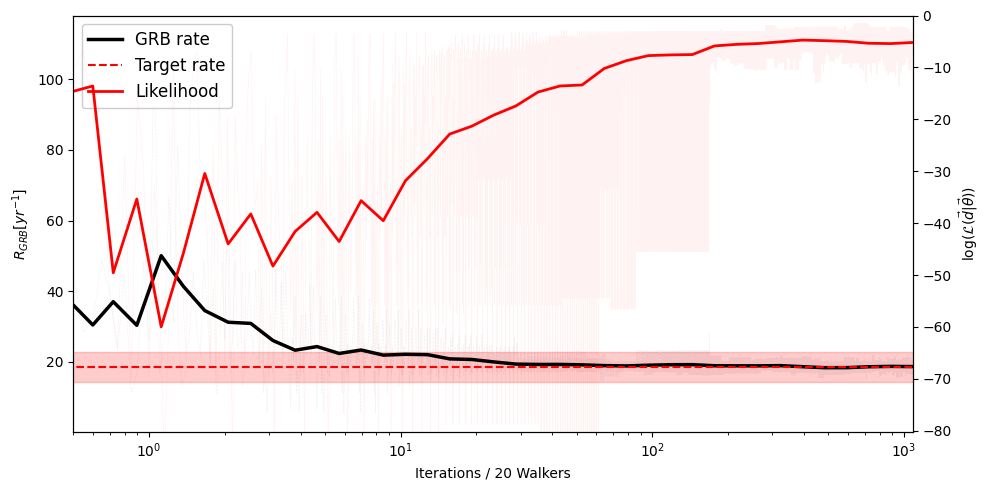

In [37]:
plotter.plot_convergence(n_counts=default_params.yearly_rate)

### Autocorrelation Times

The chain has converged when $\hat{\tau} < N / 50$.

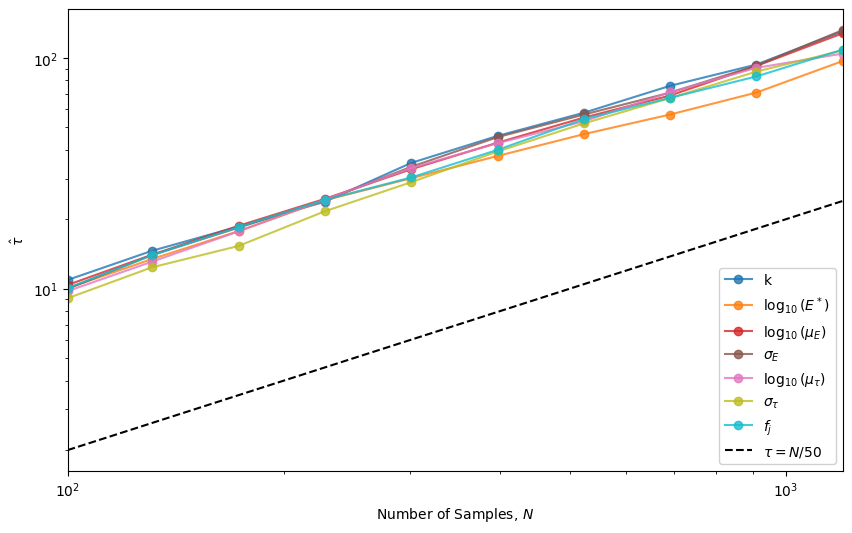

In [38]:
plotter.plot_autocorrelation_times()

### Exploration Diagnostics

- **Left panels**: Walker exploration ("fuzzy caterpillar" = good)
- **Right panels**: Autocorrelation function (should drop to zero quickly)

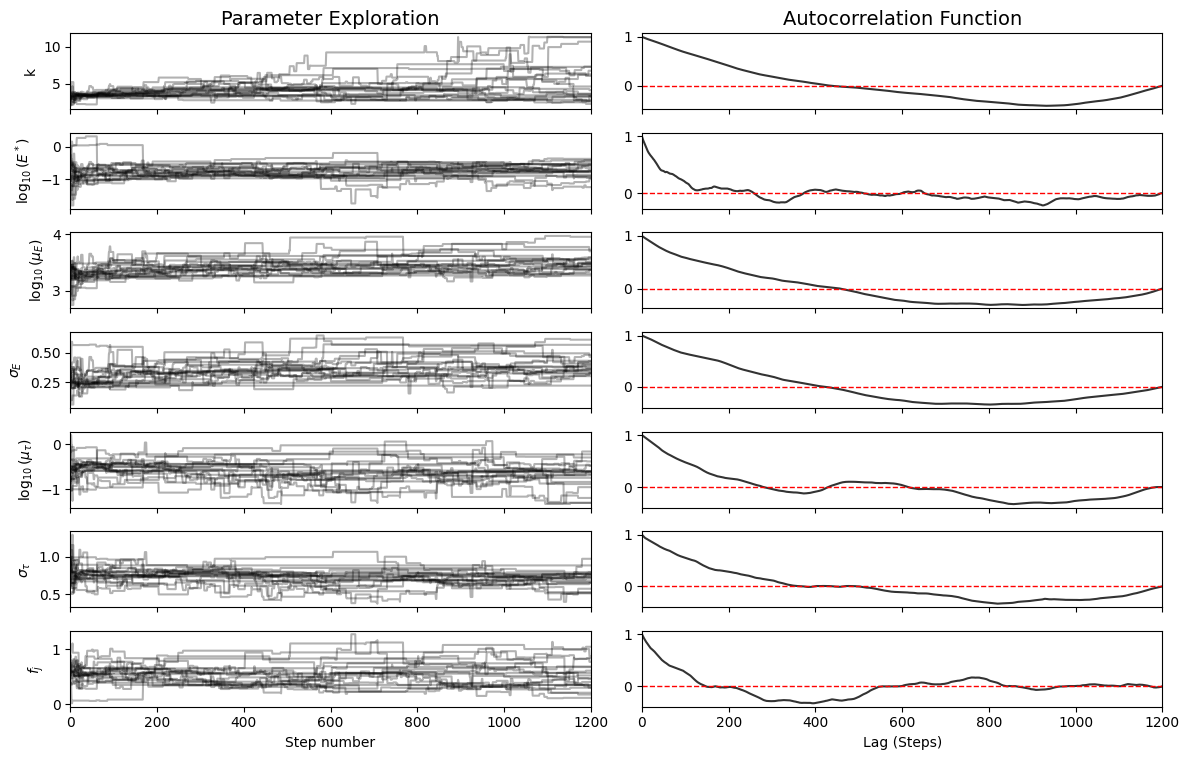

In [39]:
plotter.plot_diagnostics()

### Corner Plot

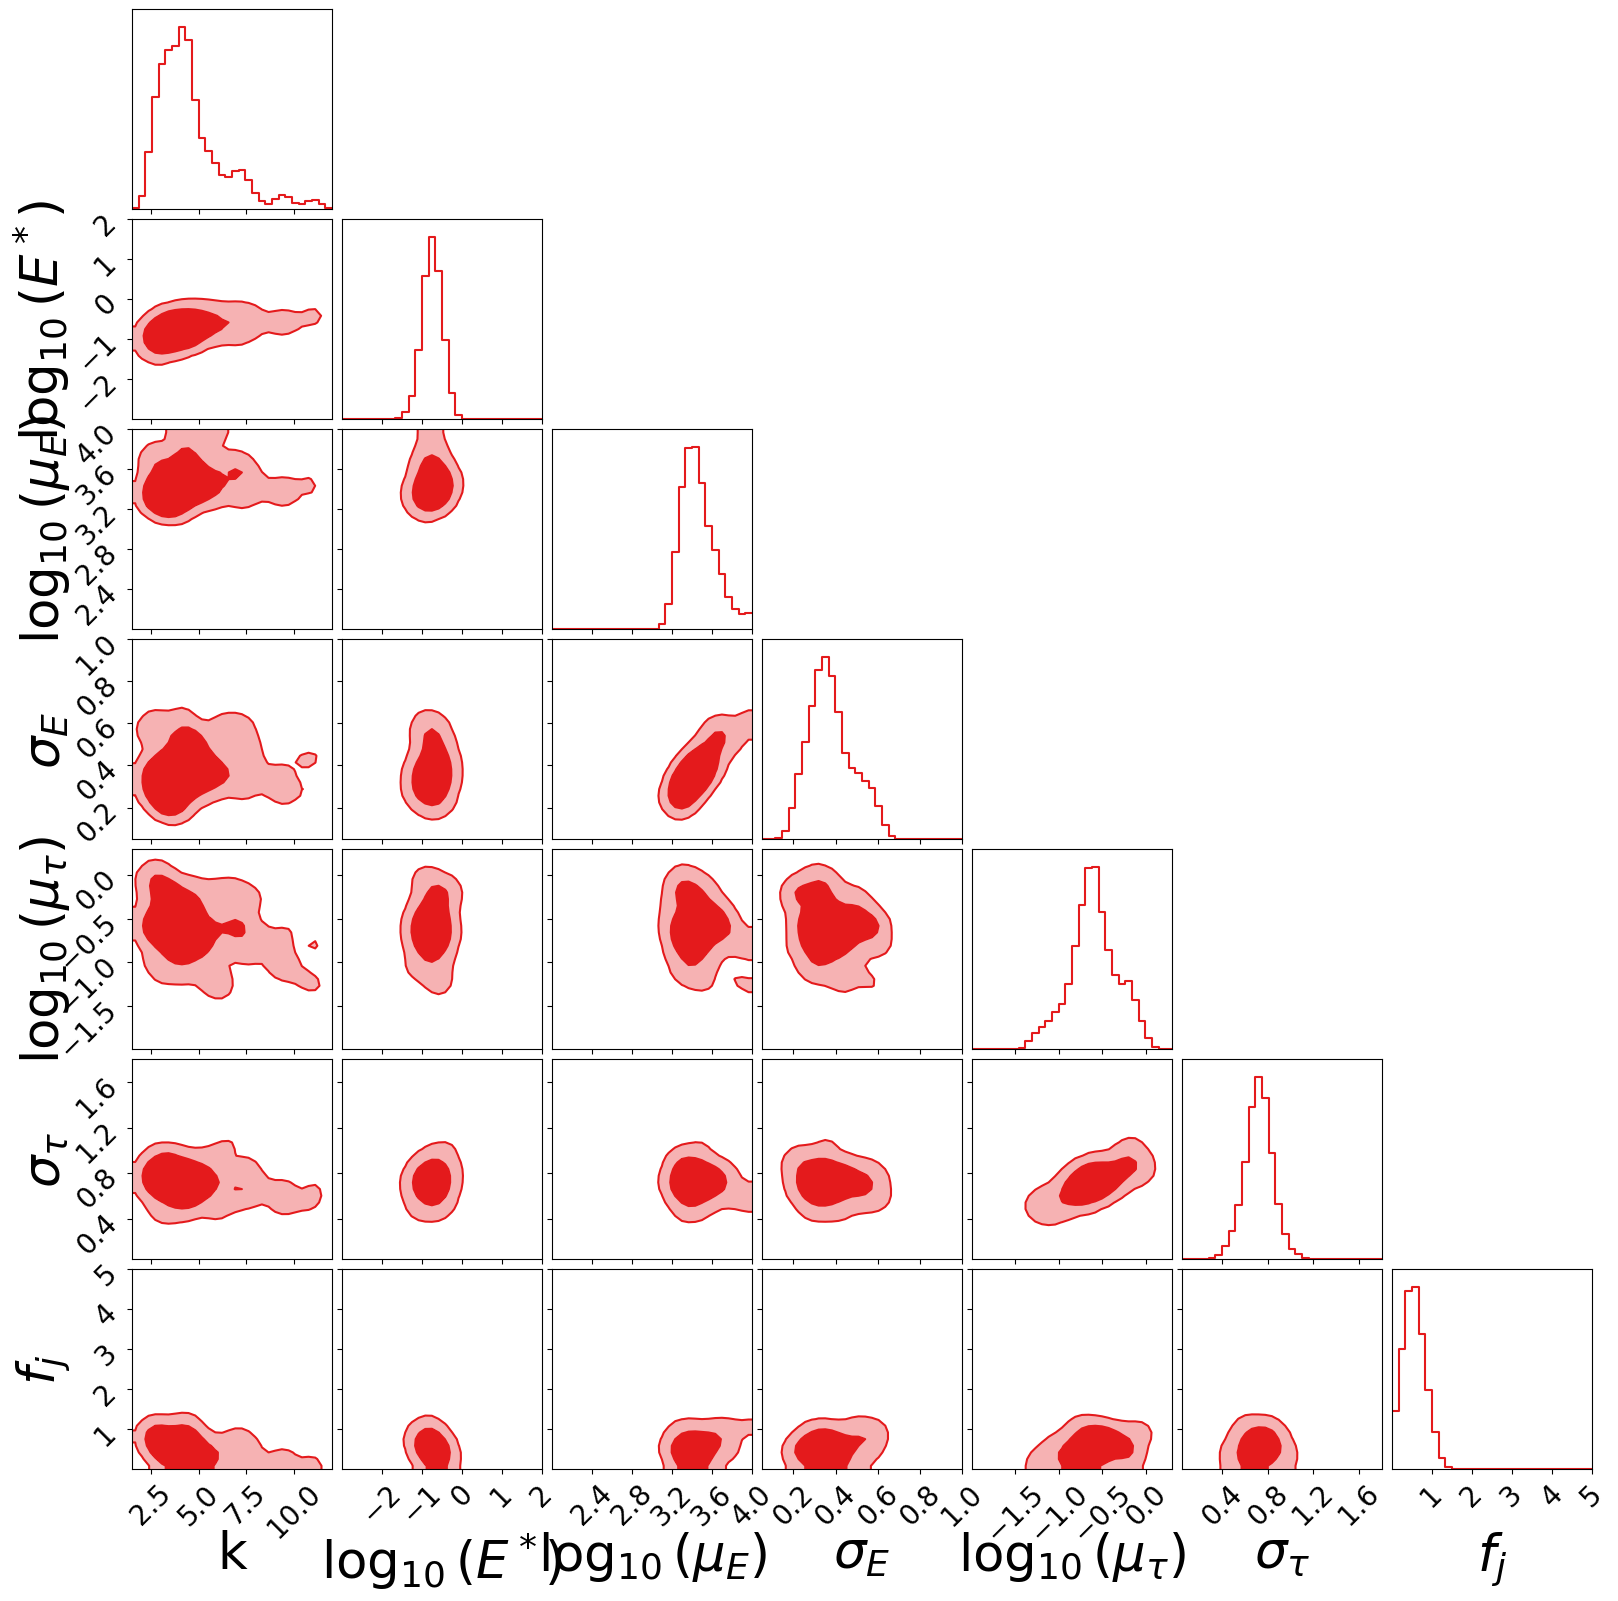

In [40]:
fig = plotter.create_corner_plot(filename="corner_structured_jet")

### Parameter Summary

In [41]:
table = plotter.show_parameter_table()

<IPython.core.display.Math object>

## 8. Posterior Predictive Checks (CDFs)

The most rigorous test: draw parameter samples from the posterior, generate observables, and compare their CDFs to the Fermi-GBM data.

The colored bands show the distribution of simulated CDFs, while the black line is the observed data.

Saving CDF comparison plot to Output_files/tutorial2_structured/CDF_comparison.pdf


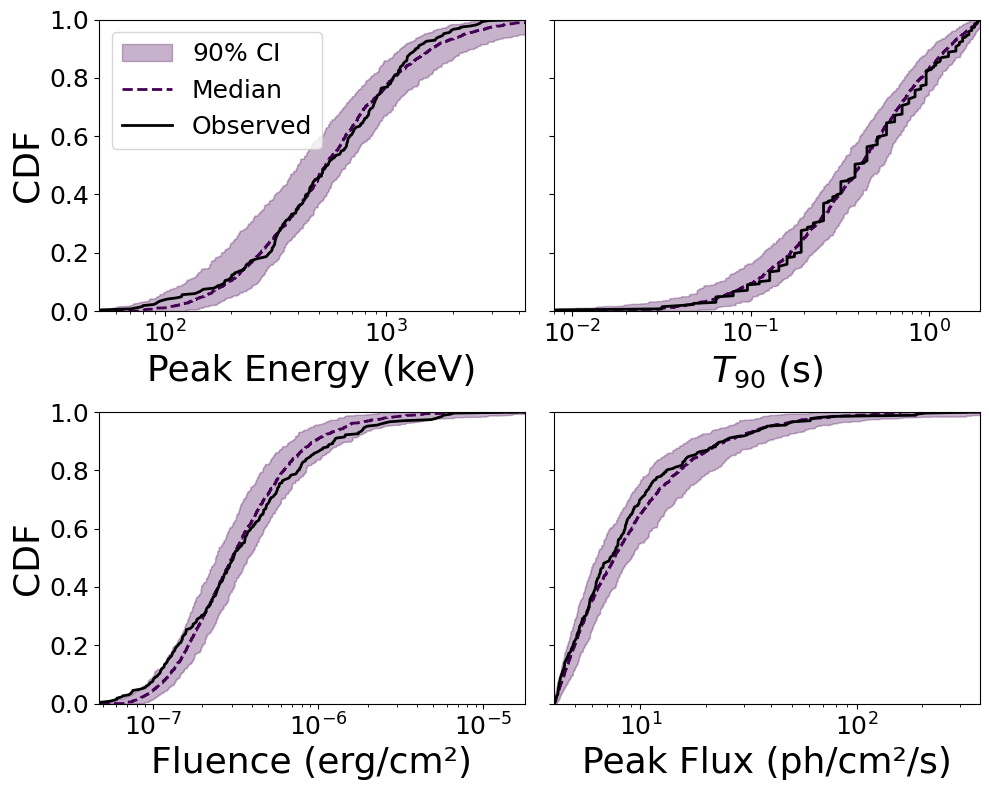

(<Figure size 1000x800 with 4 Axes>,
 array([[<Axes: xlabel='Peak Energy (keV)', ylabel='CDF'>,
         <Axes: xlabel='$T_{90}$ (s)'>],
        [<Axes: xlabel='Fluence (erg/cm²)', ylabel='CDF'>,
         <Axes: xlabel='Peak Flux (ph/cm²/s)'>]], dtype=object))

In [42]:
dict_data = posteriors.extract_samples_and_calculate_cdfs(
    backend,
    default_params,
    default_interpolator,
    discard = DISCARD,
    flatten = False,
    choices = 150  # Number of posterior samples to draw
)

plots_oop.plot_cdf_comparison(data_dict, [dict_data], output_dir=output_dir)

---

## 9. Generating Observables with Custom Cuts

One of the most powerful features of MAGGPY is the ability to generate GRB observables with **custom detection cuts**. This lets you predict what different experiments would observe.

### Example: Relaxed Cuts (e.g., for a wider-field or more sensitive detector)

Instead of the Fermi-GBM cuts  ($F_p > 4\,\text{ph}/\text{cm}^2/\text{s}$, $E_p \in [50, 10000]\,\text{keV}$), you can define custom limits and generate the corresponding observable distributions.

In [43]:
# Define custom detection limits (e.g., for a different instrument)
CUSTOM_LIMITS = {
    "F_LIM"         : 0,         # No flux cut (or set to instrument sensitivity)
    "T90_LIM"       : 200,       # Accept all durations
    "EP_LIM_UPPER"  : 10_000,    # keV
    "EP_LIM_LOWER"  : 0,         # No lower energy threshold
}

print("Default Fermi-GBM limits:", DEFAULT_LIMITS)
print("Custom limits:           ", CUSTOM_LIMITS)

Default Fermi-GBM limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Custom limits:            {'F_LIM': 0, 'T90_LIM': 200, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 0}


### Generate with a Wider Viewing Angle

To capture more off-axis events, we re-initialize the simulation with a larger $\theta_{v,\max}$.

In [44]:
params_wide = {
    "alpha"       : -0.67,
    "beta_s"      : -2.59,
    "n"           : 2,
    "theta_c"     : 3.4,
    "theta_v_max" : 20,        # <-- Wider viewing angle, useful for more sensitive detectors
    "z_model"     : 'fiducial_Hrad_A1.0' # Just use the actual fiducial model
}

default_params_wide, default_interp_wide, _ = init.initialize_simulation(
    datafiles, params_wide, size_test=10_000
)

Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 325, Trigger years: 17.50, Yearly rate: 18.58 events/year


In [45]:
# Generate observables using best-fit parameters with custom cuts
dict_custom = posteriors.extract_samples_and_calculate_cdfs(
    backend,
    default_params_wide,
    default_interp_wide,
    discard  = DISCARD,
    flatten  = False,
    choices  = 10,           # Fewer samples for quick check
    limits   = CUSTOM_LIMITS,
    use_best = True          # Use the best-fit sample
)

Best samples are used for PPC: [ 2.82771841 -0.95751018  3.39038304  0.32731087 -0.37818503  0.78970825
  0.74304841]


### Compare Detected Viewing Angles and Redshifts

With custom cuts, we can study the population of GRBs that different experiments would detect.

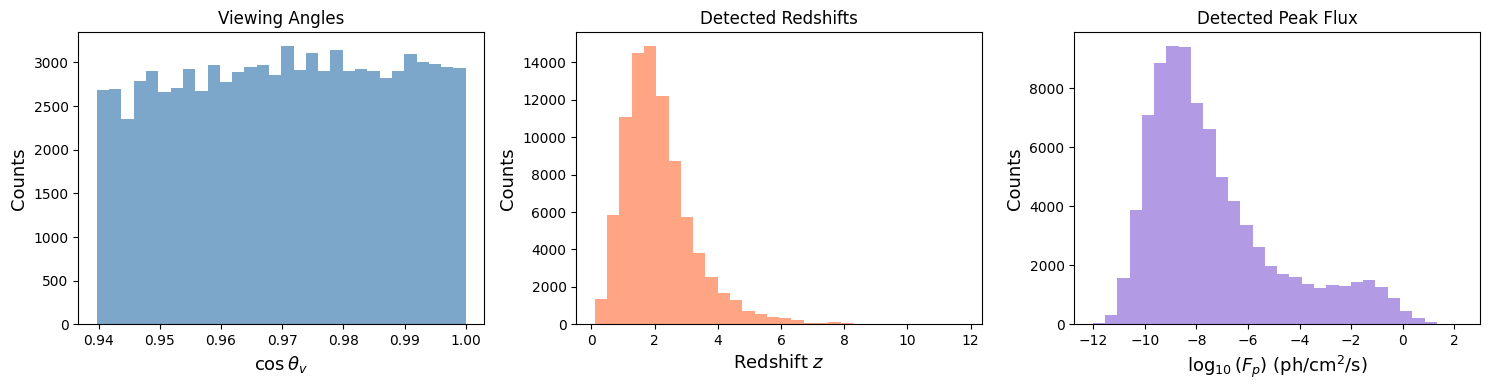

Total detected events: 86441
Median viewing angle:  13.9 deg
Median redshift:       1.932
Median peak flux:      8.900e-09 ph/cm²/s


In [46]:
# Extract detected properties from the custom-cut sample
theta_det = np.concatenate(dict_custom["theta_det"])
z_det     = np.concatenate(dict_custom["z_det"])
pflux_det = np.concatenate(dict_custom["pflux"])

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Viewing angle distribution
axes[0].hist(np.cos(theta_det), bins=30, color='steelblue', alpha=0.7)
axes[0].set_xlabel(r'$\cos\theta_v$', fontsize=13)
axes[0].set_ylabel('Counts', fontsize=13)
axes[0].set_title('Viewing Angles', fontsize=12)

# Redshift distribution
axes[1].hist(z_det, bins=30, color='coral', alpha=0.7)
axes[1].set_xlabel('Redshift $z$', fontsize=13)
axes[1].set_ylabel('Counts', fontsize=13)
axes[1].set_title('Detected Redshifts', fontsize=12)

# Peak flux distribution
axes[2].hist(np.log10(pflux_det), bins=30, color='mediumpurple', alpha=0.7)
axes[2].set_xlabel(r'$\log_{10}(F_p)$ (ph/cm$^2$/s)', fontsize=13)
axes[2].set_ylabel('Counts', fontsize=13)
axes[2].set_title('Detected Peak Flux', fontsize=12)

plt.tight_layout()
plt.savefig(output_dir / "custom_cuts_distributions.pdf", dpi=300, bbox_inches='tight')
plt.show()

print(f"Total detected events: {len(theta_det)}")
print(f"Median viewing angle:  {np.median(np.rad2deg(theta_det)):.1f} deg")
print(f"Median redshift:       {np.median(z_det):.3f}")
print(f"Median peak flux:      {np.median(pflux_det):.3e} ph/cm²/s")

### Using `make_observations_w_sensitivity`

For a more realistic treatment, the `predictions` module includes sensitivity curves. Here we generate a multi-year catalogue.

In [47]:
import src.predictions as predictions

# Get best-fit parameters from the chain
flat_chain   = backend.get_chain(discard=DISCARD, flat=True)
flat_logprob = backend.get_log_prob(discard=DISCARD, flat=True)
best_idx     = np.argmax(flat_logprob)
thetas_best  = flat_chain[best_idx]

print(f"Best-fit parameters: {thetas_best}")
print(f"Best log-probability: {flat_logprob[best_idx]:.2f}")

Best-fit parameters: [ 2.82771841 -0.95751018  3.39038304  0.32731087 -0.37818503  0.78970825
  0.74304841]
Best log-probability: -5.34


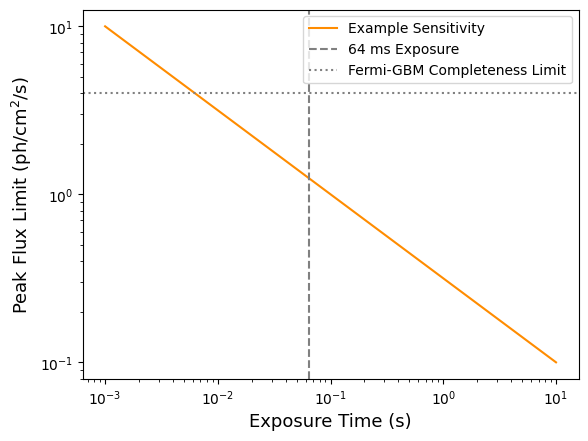

In [48]:
time_exposure = np.logspace(-3, 1, 100)  # From 1 ms to 10 s
peak_flux_lim = predictions.peak_flux_lim(time_exposure)

plt.loglog(time_exposure, peak_flux_lim, color='darkorange', label='Example Sensitivity')
plt.axvline(0.064, color='gray', linestyle='--', label='64 ms Exposure')
plt.axhline(4, color='gray', linestyle=':', label='Fermi-GBM Completeness Limit')
plt.xlabel('Exposure Time (s)', fontsize=13)
plt.ylabel(r'Peak Flux Limit (ph/cm$^2$/s)', fontsize=13)
plt.legend()
plt.show()

Detected 659 events over 10 years
Rate: 65.9 events/yr


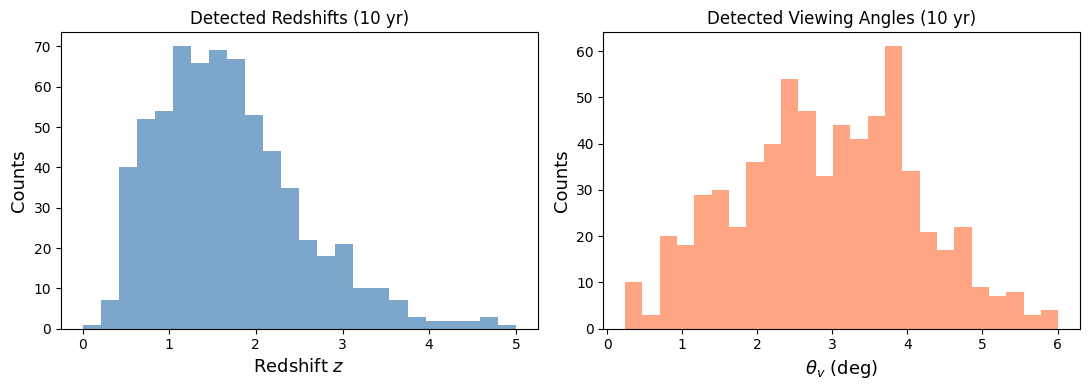

In [49]:
# Generate 10 years of observations
n_years = 10

obs = predictions.make_observations_w_sensitivity(
    thetas_best,
    params = default_params,
    interps = default_interpolator,
    limits  = predictions.DEFAULT_LIMITS_GRINTA,
    n_yrs   = n_years
)

if obs is not None:
    print(f"Detected {len(obs['z_det'])} events over {n_years} years")
    print(f"Rate: {len(obs['z_det']) / n_years:.1f} events/yr")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
    
    bins_z = np.linspace(0, 5, 25)
    ax1.hist(obs['z_det'], bins=bins_z, color='steelblue', alpha=0.7)
    ax1.set_xlabel('Redshift $z$', fontsize=13)
    ax1.set_ylabel('Counts', fontsize=13)
    ax1.set_title(f'Detected Redshifts ({n_years} yr)', fontsize=12)
    
    ax2.hist(np.rad2deg(obs['theta_v_det']), bins=25, color='coral', alpha=0.7)
    ax2.set_xlabel(r'$\theta_v$ (deg)', fontsize=13)
    ax2.set_ylabel('Counts', fontsize=13)
    ax2.set_title(f'Detected Viewing Angles ({n_years} yr)', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(output_dir / "predicted_detections.pdf", dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No events detected — try adjusting parameters.")

### Export a Simulated Catalogue

You can export the simulated catalogue for use with external tools (e.g., detection efficiency calculations).

In [50]:
import pandas as pd

if obs is not None:
    cat = pd.DataFrame({
        'z'         : obs['z_det'],
        'theta_v'   : np.rad2deg(obs['theta_v_det']),
        'Ep_obs'    : obs['Ep_det'],
        'Fp'        : obs['Fp_phot'],
        'T90'       : obs['t_det'],
    })

    cat_path = output_dir / "simulated_catalogue.csv"
    cat.to_csv(cat_path, index=False)
    print(f"Saved {len(cat)} events to {cat_path}")

Saved 659 events to Output_files/tutorial2_structured/simulated_catalogue.csv


In [51]:
cat.describe()

,z,theta_v,Ep_obs,Fp,T90
count,659.000000,659.000000,659.000000,659.000000,659.000000
mean,1.689740,2.911695,705.367631,11.644791,0.792048
std,0.837190,1.188030,770.306934,37.818722,0.548444
min,0.145615,0.240130,60.466643,0.506435,0.009434
25%,1.075614,2.031404,275.292592,1.540214,0.314604
50%,1.582043,2.894702,475.721266,3.004289,0.713869
75%,2.150834,3.782950,854.783117,6.678414,1.177223
max,4.819642,6.009909,8111.871616,563.058359,1.992379


---

## 10. Viewing Angle vs Redshift: Selection Effects

A key prediction of structured jet models is the **strong selection bias** in $(\theta_v, z)$ space. Nearby events can be detected even at large viewing angles, but distant events must be close to on-axis.

Let's generate a large population and compare the full population to the detected sub-sample.

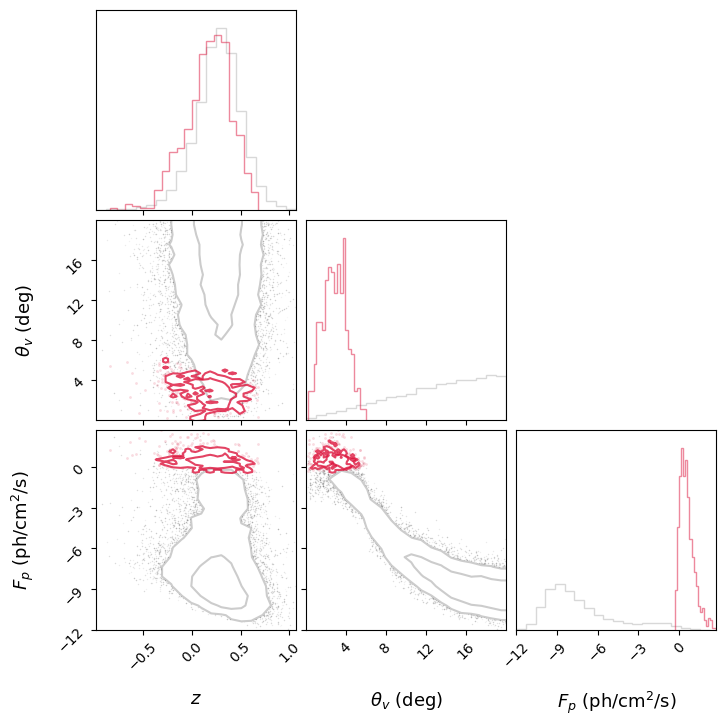

In [52]:
import corner

# Generate a larger population to see the selection effect clearly
n_years_plot = 20

theta_det_all = np.concatenate(dict_custom["theta_det"])
z_det_all     = np.log10(np.concatenate(dict_custom["z_det"]))
pflux_det_all = np.log10(np.concatenate(dict_custom["pflux"]))

theta_det_sens = obs["theta_v_det"]
z_det_sens     = np.log10(obs["z_det"])
pflux_det_sens = np.log10(obs["Fp_phot"])

data_sens = np.column_stack([z_det_sens, np.rad2deg(theta_det_sens), pflux_det_sens])
data_det = np.column_stack([z_det_all, np.rad2deg(theta_det_all), pflux_det_all])

labels = [r'$z$', r'$\theta_v$ (deg)', r'$F_p$ (ph/cm$^2$/s)']

fig_corner = corner.corner(
    data_det,
    labels=labels,
    color='grey',
    plot_datapoints=True,
    plot_density=False,
    plot_contours=True,
    levels=[0.5, 0.9],
    hist_kwargs=dict(density=True, alpha=0.3),
    contour_kwargs=dict(alpha=0.4),
    data_kwargs=dict(alpha=0.05, ms=1),
    label_kwargs=dict(fontsize=13),
)

corner.corner(
    data_sens,
    labels=labels,
    color='crimson',
    fig=fig_corner,
    plot_datapoints=True,
    plot_density=False,
    plot_contours=True,
    levels=[0.5, 0.9],
    hist_kwargs=dict(density=True, alpha=0.5),
    contour_kwargs=dict(alpha=0.8),
    data_kwargs=dict(alpha=0.15, ms=2),
)

plt.show()

Detected sGRBs are strongly clustered at **low $\theta_v$ and low $z$**, exactly as expected from the combination of geometric beaming and cosmological dimming ($1/D^2$ scaling). 

This kind of plot is essential for understanding what current and future detectors (Fermi, SVOM, HERMES, Einstein Probe) can probe.

---

## Summary

In this tutorial we:

1. **Explained** the structured jet physics: angular profiles, temporal evolution, SBPL spectrum
2. **Defined** the 7-parameter model with flat priors
3. **Initialized** the simulation (spectral integrals, temporal interpolators, angular structure)
4. **Ran an MCMC** using `emcee` with multiprocessing
5. **Checked convergence** via rate evolution, autocorrelation times, and walker diagnostics
6. **Performed posterior predictive checks** comparing simulated CDFs to Fermi-GBM data
7. **Generated observables with custom cuts** for different experiments
8. **Exported** a simulated GRB catalogue
9. **Visualised selection effects** in the $\theta_v$–$z$ plane

**Next:** Tutorial 3 will show how to combine these results with GWFish for joint GW+GRB detection efficiency studies.